# Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Plot Examples

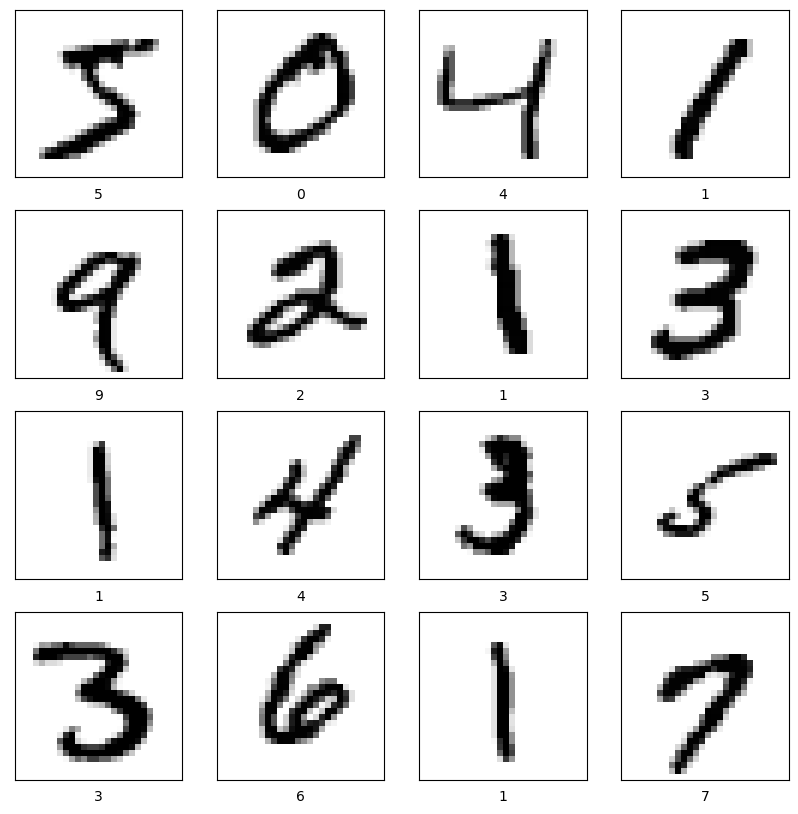

In [3]:
plt.figure(figsize = (10, 10))
for i in range(0, 16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(x_train[i], cmap = 'binary')
  plt.xlabel(str(y_train[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# Normalize Data

In [4]:
x_train = np.reshape(x_train, (60000, 28 * 28))
x_test = np.reshape(x_test, (10000, 28 * 28))

In [5]:
x_train = x_train / 255
x_test = x_test / 255

In [6]:
x_train.shape

(60000, 784)

# Create a Neural Network Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation = 'sigmoid', input_shape = (784, )),
    tf.keras.layers.Dense(32, activation = 'sigmoid'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [8]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Train the Model

In [9]:
_ = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20,
    batch_size = 2048,
    verbose = 2
)

Epoch 1/20


2023-08-08 01:28:06.477809: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 - 0s - loss: 2.3671 - accuracy: 0.1631 - val_loss: 2.2016 - val_accuracy: 0.2260 - 428ms/epoch - 14ms/step
Epoch 2/20
30/30 - 0s - loss: 2.1189 - accuracy: 0.4275 - val_loss: 2.0226 - val_accuracy: 0.5836 - 124ms/epoch - 4ms/step
Epoch 3/20
30/30 - 0s - loss: 1.9433 - accuracy: 0.6220 - val_loss: 1.8422 - val_accuracy: 0.6610 - 116ms/epoch - 4ms/step
Epoch 4/20
30/30 - 0s - loss: 1.7571 - accuracy: 0.6699 - val_loss: 1.6508 - val_accuracy: 0.6941 - 124ms/epoch - 4ms/step
Epoch 5/20
30/30 - 0s - loss: 1.5669 - accuracy: 0.7131 - val_loss: 1.4629 - val_accuracy: 0.7378 - 136ms/epoch - 5ms/step
Epoch 6/20
30/30 - 0s - loss: 1.3859 - accuracy: 0.7505 - val_loss: 1.2901 - val_accuracy: 0.7798 - 137ms/epoch - 5ms/step
Epoch 7/20
30/30 - 0s - loss: 1.2227 - accuracy: 0.7893 - val_loss: 1.1370 - val_accuracy: 0.8098 - 132ms/epoch - 4ms/step
Epoch 8/20
30/30 - 0s - loss: 1.0794 - accuracy: 0.8157 - val_loss: 1.0040 - val_accuracy: 0.8349 - 138ms/epoch - 5ms/step
Epoch 9/20
30/30 - 0s - lo

# Save the Model

In [10]:
model.save('model.h5')

# ML Server

In [14]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(
  model.inputs,
  [layer.output for layer in model.layers]
)

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
  index = np.random.choice(x_test.shape[0])
  image = x_test[index, :, :]
  image_arr = np.reshape(image, (1, 784))
  return feature_model.predict(image_arr), image

@app.route('/', methods = ['GET', 'POST'])
def index():
  if request.method == 'POST':
    preds, image = get_prediction()
    final_preds = [p.tolist() for p in preds]
    return json.dumps({
      'prediction' : final_preds,
      'image' : image.tolist()
    })
  return 'Welcome to the model server! '

if __name__ == '__main__':
  app.run()



Overwriting ml_server.py


# Streamlit Web App

In [19]:
%%writefile app.py

import json
import streamlit as st 
import requests
import matplotlib.pyplot as plt 
import numpy as np


URI='http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')
st.set_option('deprecation.showPyplotGlobalUse', False)


if st.button('Get random prediction'):
  response =  requests.post(URI, data={})
  response = json.loads(response.text)
  preds = response.get('prediction')
  image = response.get('image')
  image = np.reshape(image, (28,28))
  
  st.sidebar.image(image, width = 150)
  
  for layer, p in enumerate(preds):
    numbers = np.squeeze(np.array(p))
    
    plt.figure(figsize = (32, 4))
    
    if layer == 2:
      row = 1
      col = 10
    else:
      row = 2
      col = 16
    
    for i, number in enumerate(numbers): 
      plt.subplot(row, col, i + 1)

      plt.imshow(number * np.ones((8, 8, 3)).astype('float32'))

      plt.xticks([]) 
      plt.yticks([])

      if layer == 2:

        plt.xlabel(str(i), fontsize=40)

    plt.subplots_adjust(wspace=0.05, hspace=0.05) 
    plt.tight_layout()
    st.text('Layer {}'.format(i + 1))
    st.pyplot()



Overwriting app.py
